In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import umap

from matplotlib import pyplot as plt
from re import search
from os import listdir
from scipy import stats

c:\Users\Localadmin_kangzigi\.conda\envs\numba_napari\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Localadmin_kangzigi\.conda\envs\numba_napari\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Localadmin_kangzigi\.conda\envs\numba_napari\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Localadmin_kangzigi\.conda\envs\numba_napari\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def get_file_list(folder): 
    files = [os.path.join(folder, f) for f in listdir(folder) if search('tribus_annotated.csv', f)]
    return files

In [5]:
folder = 'P:/afarkkilab/Projects/NKI/Whole_slide_validation/tribus_analysis/output_data'
image_path = get_file_list(folder)
image_path

['P:/afarkkilab/Projects/NKI/Whole_slide_validation/tribus_analysis/output_data\\S050_iAdn_logic_table8_raw_tribus_annotated.csv',
 'P:/afarkkilab/Projects/NKI/Whole_slide_validation/tribus_analysis/output_data\\S057_iOme_logic_table8_raw_tribus_annotated.csv',
 'P:/afarkkilab/Projects/NKI/Whole_slide_validation/tribus_analysis/output_data\\S065_iOme_logic_table8_raw_tribus_annotated.csv',
 'P:/afarkkilab/Projects/NKI/Whole_slide_validation/tribus_analysis/output_data\\S072_iOme_logic_table8_raw_tribus_annotated.csv',
 'P:/afarkkilab/Projects/NKI/Whole_slide_validation/tribus_analysis/output_data\\S073_iOme1_logic_table8_raw_tribus_annotated.csv',
 'P:/afarkkilab/Projects/NKI/Whole_slide_validation/tribus_analysis/output_data\\S081_iOme_logic_table8_raw_tribus_annotated.csv',
 'P:/afarkkilab/Projects/NKI/Whole_slide_validation/tribus_analysis/output_data\\S083_iOme1_logic_table8_raw_tribus_annotated.csv',
 'P:/afarkkilab/Projects/NKI/Whole_slide_validation/tribus_analysis/output_data\\

## Barplot

In [6]:
all_count_df = pd.DataFrame()

for image_loc in image_path: 
    sample_name = re.findall(r'\\(S\d+_i\w+?)_', image_loc)
    print(sample_name)
    
    result_data = pd.read_csv('{}'.format(image_loc))
    count_df = pd.DataFrame(result_data.final_label.value_counts(normalize=True).reset_index())
    count_df = count_df.assign(sample=np.repeat(sample_name, len(count_df["final_label"])))
    all_count_df = pd.concat([all_count_df, count_df], ignore_index=True)

['S050_iAdn']
['S057_iOme']
['S065_iOme']
['S072_iOme']
['S073_iOme1']
['S081_iOme']
['S083_iOme1']
['S084_iOme2']
['S091_iOme1']
['S098_iOme']
['S107_iOme']
['S112_iOme']
['S113_iOme']
['S118_iOme']
['S121_iOme']
['S123_iOme']
['S130_iOme']
['S131_iOme']
['S188_iOme']
['S197_iOme']
['S268_iOme']


In [8]:
all_count_df

,final_label,proportion,sample
0,Stromal,0.682323,S050_iAdn
1,CD4.T.cell,0.140700,S050_iAdn
2,Cancer,0.075412,S050_iAdn
3,IBA1.Myeloid,0.045847,S050_iAdn
4,CD8.T.cell,0.031603,S050_iAdn
...,...,...,...
142,CD4.T.cell,0.051939,S268_iOme
143,IBA1.Myeloid,0.020291,S268_iOme
144,undefined_Global,0.013625,S268_iOme
145,CD8.T.cell,0.010046,S268_iOme


In [9]:
label_mapping = {
    'Cancer': 'Cancer', 
    'Stromal': 'Stromal', 
    'Unknown': 'Other', 
    'undefined_Global': 'Other', 
    'CD4.T.cell': 'CD4.T.cell',
    'CD8.T.cell': 'CD8.T.cell', 
    'CD11c.Myeloid': 'CD11c.Myeloid', 
    'IBA1.Myeloid': 'IBA1.Myeloid', 
}

all_count_df['final_label'] = all_count_df['final_label'].replace(label_mapping)

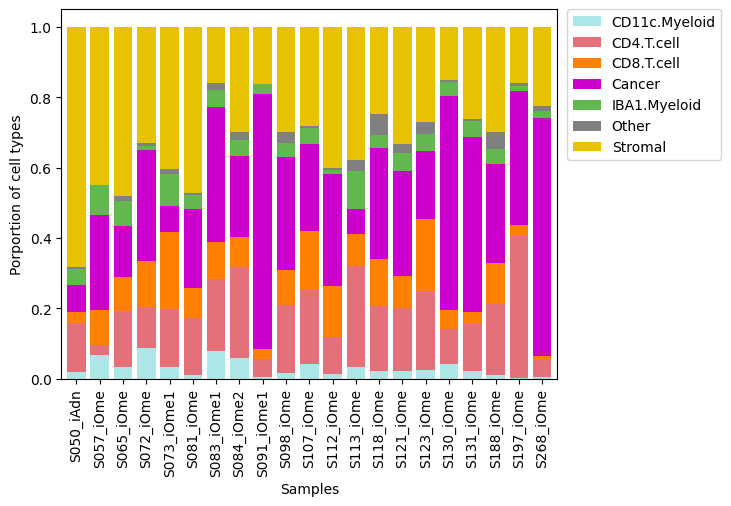

In [10]:
pivoted = all_count_df.pivot(index="sample", columns="final_label", values="proportion")

# Manually defined color map
color_map = {
    'Cancer': '#cd00cd', 
    'Stromal': '#e6c200', 
    'Other': 'grey', 
    'CD4.T.cell': '#e4717a',
    'CD8.T.cell': '#FF7F00', 
    'CD11c.Myeloid': '#ade6e6', 
    'IBA1.Myeloid': '#62B74F', 
}

colors = [color_map[label] for label in pivoted.columns]
pivoted.plot(kind='bar', stacked=True, width=0.8, color=colors)
plt.ticklabel_format(style='plain', useOffset=False, axis='y') ## No offset
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.gca().set_ylabel("Porportion of cell types")
plt.gca().set_xlabel("Samples")
plt.savefig('./Cell_num_barplot.svg')
plt.show()

## UMAP

In [11]:
all_df = pd.DataFrame()
n = 10000

kept_cols = ['CellID', 'DNA1', 'CD4', 'CK7', 'HLA-A', 'Vimentin', 'DNA2', 'PAX8', 'HLA-DPB1', 
             'PD1', 'DNA3', 'CD45RO', 'CD3D', 'CD45', 'DNA4', 'IBA1', 'CD11c', 'CD8a', 'X_centroid', 'Y_centroid', 
             'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Sample', 
             'Global', 'final_label']
cols = ['CD4', 'CK7', 'HLA-A', 'Vimentin', 'PAX8', 
        'CD45', 'IBA1', 'CD11c', 'CD8a', 'Area','Eccentricity'] # remove low quality marker: 'CD45RO','CD3D', 'PD1', 'HLA-DPB1', 

for image_loc in image_path: 
    sample_name = re.findall(r'\\(S\d+_i\w+?)_', image_loc)
    print(sample_name)
    result_data = pd.read_csv('{}'.format(image_loc))

    result_data[cols] = stats.zscore(result_data[cols])
    result_data = result_data.sample(n=n, random_state=42) # downsampling

    all_df = pd.concat([all_df, result_data], ignore_index=True)

['S050_iAdn']
['S057_iOme']
['S065_iOme']
['S072_iOme']
['S073_iOme1']
['S081_iOme']
['S083_iOme1']
['S084_iOme2']
['S091_iOme1']
['S098_iOme']
['S107_iOme']
['S112_iOme']
['S113_iOme']
['S118_iOme']
['S121_iOme']
['S123_iOme']
['S130_iOme']
['S131_iOme']
['S188_iOme']
['S197_iOme']
['S268_iOme']


In [12]:
label_mapping = {
    'Cancer': 'Cancer', 
    'Stromal': 'Stromal', 
    'Unknown': 'Other', 
    'undefined_Global': 'Other', 
    'CD4.T.cell': 'CD4.T.cell',
    'CD8.T.cell': 'CD8.T.cell', 
    'CD11c.Myeloid': 'CD11c.Myeloid', 
    'IBA1.Myeloid': 'IBA1.Myeloid', 
}

all_df['final_label'] = all_df['final_label'].replace(label_mapping)

In [13]:
# UMAP
reducer = umap.UMAP(n_neighbors=80, min_dist=0.3, n_components=2, metric='euclidean')
embedding = reducer.fit_transform(all_df[cols])

In [14]:
# Manually defined color map
color_map = {
    'Cancer': '#cd00cd', 
    'Stromal': '#e6c200', 
    'Other': 'grey', 
    'CD4.T.cell': '#e4717a',
    'CD8.T.cell': '#FF7F00', 
    'CD11c.Myeloid': '#ade6e6', 
    'IBA1.Myeloid': '#62B74F', 
}

colors = [color_map[label] for label in all_df["final_label"]]

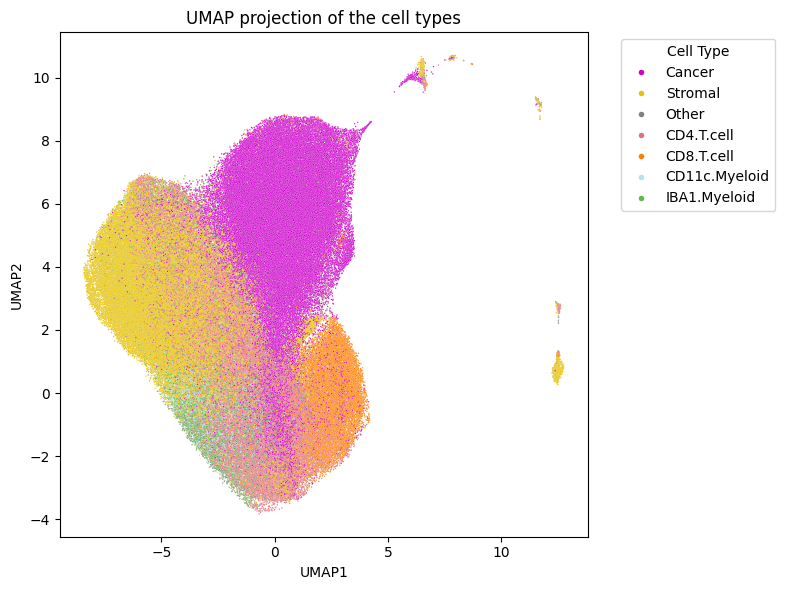

In [15]:
# Plotting global cell types
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], c = colors, s=1)
plt.title('UMAP projection of the cell types')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                      markerfacecolor=value, markersize=5) for key, value in color_map.items()]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), title="Cell Type", loc='upper left')
# lgnd = plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), scatterpoints=1, markerscale=5, loc='upper left')

plt.tight_layout()
plt.savefig('./umap_by_celltype.svg', bbox_inches='tight')
plt.savefig('./umap_by_celltype.png', dpi = 300, bbox_inches='tight')
plt.show()

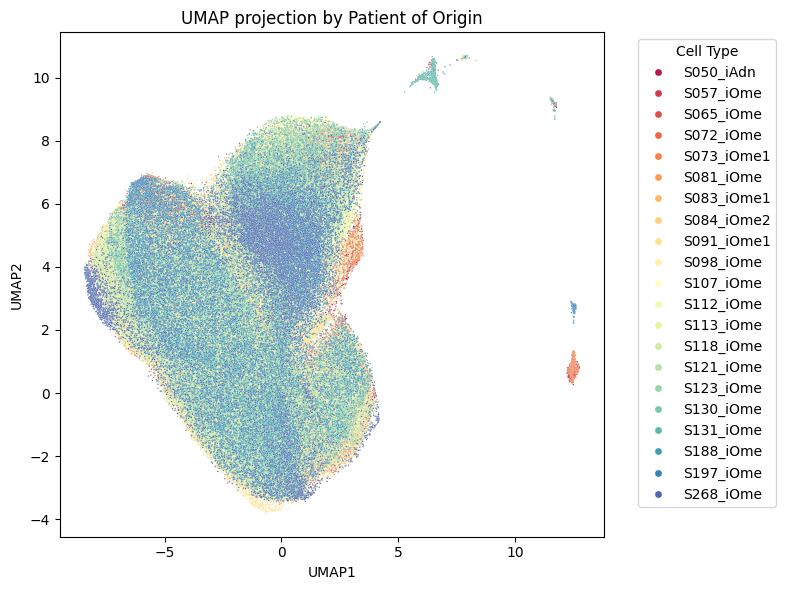

In [16]:
p2 = sns.color_palette('husl', len(all_df['Sample'].unique()))
# Colored by Patient of Origin
all_df['Sample'] = all_df['Sample'].astype('category')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=all_df['Sample'], legend='full', palette='Spectral', s=1)
plt.title('UMAP projection by Patient of Origin')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
lgnd = plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), scatterpoints=1, markerscale=5, loc='upper left')
#plt.legend(title='Patient', bbox_to_anchor=(1.05, 1), loc='lower center', ncol=3)

plt.tight_layout()
plt.savefig('./umap_by_sample.svg', bbox_inches='tight')
plt.savefig('./umap_by_sample.png', dpi = 300, bbox_inches='tight')
plt.show()